In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download --force dansbecker/cityscapes-image-pairs

 99% 199M/202M [00:07<00:00, 41.2MB/s]
100% 202M/202M [00:07<00:00, 27.9MB/s]


In [3]:
!unzip cityscapes-image-pairs.zip

Streaming output truncated to the last 5000 lines.
  inflating: cityscapes_data/cityscapes_data/train/2754.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2755.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2756.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2757.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2758.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2759.jpg  
  inflating: cityscapes_data/cityscapes_data/train/276.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2760.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2761.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2762.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2763.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2764.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2765.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2766.jpg  
  inflating: cityscapes_data/cityscapes_data/train/2767.jpg  
  inflating: citysca

In [4]:
!pip install torchmetrics
!pip install segmentation-models-pytorch
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e7f39ffc7666b3ce7046e97eb63a6d432ede7b4a7f6505b3698a02dd4e076ee8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=7334093b93862f1b83b823e2b6b0b30769bc2905f2bf5448d664b842ae954b18
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [5]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

print(torch.__version__)
print(torchvision.__version__)
print(A.__version__)

2.1.0+cu121
0.16.0+cu121
1.4.0


In [6]:
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
from PIL import Image
import cv2

In [7]:
trainpth = "cityscapes_data/train"
valpth = "cityscapes_data/val"
traindir = os.listdir(trainpth)
valdir = os.listdir(valpth)
print(len(traindir), len(valdir))

2975 500


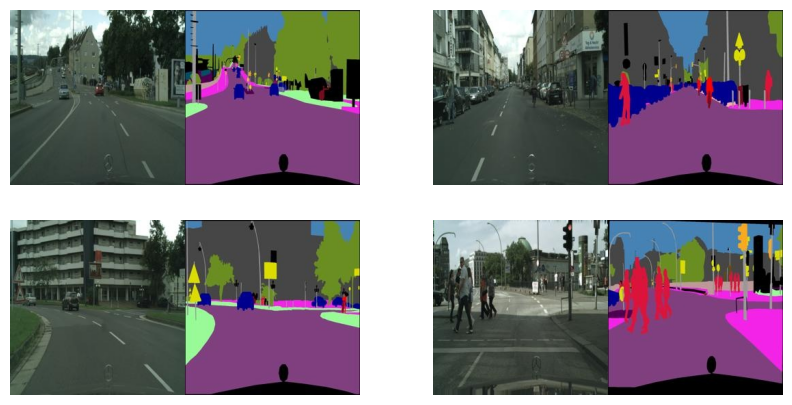

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.axis(False)
  img = Image.open(trainpth+"/"+traindir[2*i+2*i])
  plt.imshow(img)

In [8]:
idx_to_name = ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']
idx_to_class = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

name_to_color = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [111, 74,  0], [81, 0, 81], [128, 64, 128], [244, 35, 232], [250, 170, 160], [230, 150, 140], [70, 70, 70],
                [102, 102, 156], [190, 153, 153], [180, 165, 180], [150, 100, 100], [150, 120, 90], [153,153,153], [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35],
                [152, 251, 152], [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 0, 90], [0, 0, 110], [0, 80, 100], [0, 0, 230],
                [119, 11, 32], [0, 0, 142]])

name_to_class = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2, 17 : 3,
                18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

name_to_class_map = lambda x: name_to_class[x]
name_to_class_map = np.vectorize(name_to_class_map)

name_to_color_map = lambda x: name_to_color[x]
name_to_color_map = np.vectorize(name_to_color_map)

def encode_segmap(mask, sparse_mapping=False):
  h, w, c = mask.shape
  distances = np.sum((mask.reshape(-1, c)[:, np.newaxis, :] - name_to_color)**2, axis=2)
  label = np.argmin(distances, axis=1).reshape(h, w)

  if sparse_mapping:
      label = name_to_class_map(label)

  return label

print(len(idx_to_name))
print(len(idx_to_class))


35
8


[[[ 6  8  5]
  [ 0  0  0]
  [ 6  6  6]
  ...
  [ 0  0  0]
  [ 1  1  1]
  [ 7  7  7]]

 [[ 0  1  0]
  [ 2  2  2]
  [33 33 33]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 2  2  2]]

 [[ 0  1  0]
  [ 5  5  5]
  [53 53 53]
  ...
  [ 2  2  2]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[ 0  1  3]
  [ 0  1  3]
  [ 0  1  5]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  2  1]
  [ 1  1  1]
  [ 1  1  3]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 1  3  2]
  [ 2  2  2]
  [ 3  1  2]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
(256, 256, 3)


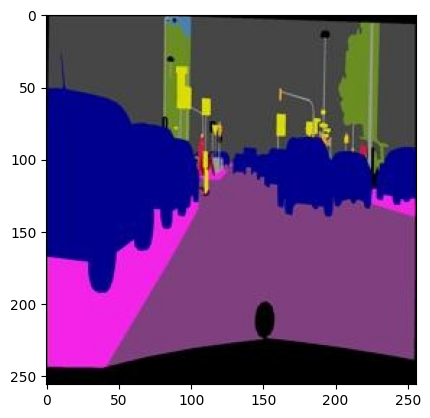

In [ ]:
pic = plt.imread(valpth + "/" + valdir[5])
img, mask = pic[:, :int(pic.shape[1]/2)], pic[:, int(pic.shape[1]/2):]
img, mask = np.array(img), np.array(mask, dtype=np.uint8)
print(mask)
print(mask.shape)
plt.imshow(mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(256, 256)


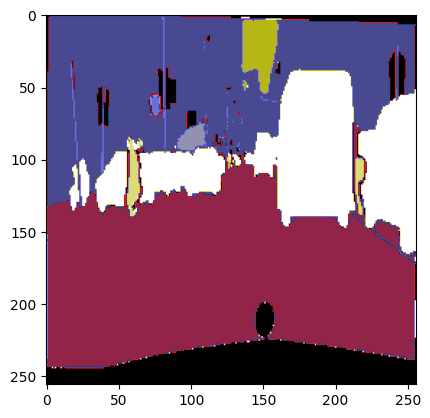

In [ ]:
label = encode_segmap(mask, True)
print(label)
print(label.shape)
plt.imshow(label, cmap='gist_stern')

In [9]:
class RGBSegmentationDataset(Dataset):
  def __init__(self, imgpth, transform):
    super().__init__()

    self.imgpth = imgpth
    self.imgdir = os.listdir(imgpth)
    self.transform = transform

  def __len__(self):
    return len(self.imgdir)

  def __getitem__(self, idx):
    pic = plt.imread(self.imgpth + "/" + self.imgdir[idx])
    img, mask = pic[:, :int(pic.shape[1]/2)], pic[:, int(pic.shape[1]/2):]

    img, mask = np.array(img, dtype=np.float64), np.array(mask, dtype=np.uint8)
    img /= 255.0
    mask = encode_segmap(mask, True)

    augmentations = self.transform(image=img, mask=mask)
    img, mask = torch.from_numpy(augmentations['image']).float().permute(2, 0, 1), torch.from_numpy(augmentations['mask']).long()
    #print(img.shape, mask.shape)

    return (img, mask)

transform = A.Compose([
    #A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    #ToTensorV2()
])

trainset = RGBSegmentationDataset(trainpth, transform)
valset = RGBSegmentationDataset(valpth, transform)

In [10]:
gpu = "cuda" if torch.cuda.is_available() else "cpu"
print(gpu)

batchsize = 32
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
valloader = DataLoader(valset, batch_size=batchsize, shuffle=False)

cpu


In [ ]:
for (x, y) in valloader:
  print(x.shape, y.shape)
  print(x)
  print(y)
  break

torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])
tensor([[[[-2.1164, -2.1166, -2.1168,  ..., -2.1145, -2.1145, -2.1145],
          [-2.1166, -2.1167, -2.1168,  ..., -2.1145, -2.1145, -2.1145],
          [-2.1166, -2.1168, -2.1168,  ..., -2.1144, -2.1145, -2.1145],
          ...,
          [-2.1145, -2.1149, -2.1148,  ..., -2.1147, -2.1147, -2.1147],
          [-2.1145, -2.1147, -2.1146,  ..., -2.1147, -2.1147, -2.1147],
          [-2.1140, -2.1143, -2.1143,  ..., -2.1147, -2.1147, -2.1147]],

         [[-2.0336, -2.0337, -2.0338,  ..., -2.0324, -2.0324, -2.0325],
          [-2.0337, -2.0337, -2.0338,  ..., -2.0324, -2.0324, -2.0325],
          [-2.0337, -2.0338, -2.0338,  ..., -2.0324, -2.0324, -2.0324],
          ...,
          [-2.0321, -2.0317, -2.0317,  ..., -2.0316, -2.0316, -2.0316],
          [-2.0319, -2.0316, -2.0315,  ..., -2.0316, -2.0316, -2.0316],
          [-2.0315, -2.0311, -2.0311,  ..., -2.0316, -2.0316, -2.0316]],

         [[-1.8027, -1.8028, -1.8029,  ..., -

In [11]:
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.losses import JaccardLoss
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics import Dice

iou = MulticlassJaccardIndex(num_classes=len(idx_to_class))
dice = Dice(num_classes=len(idx_to_class))

def trainloop(model, trainloader, lossfn, optim):
  totals = [0, 0, 0]

  model.train()

  for batch, (x, y) in tqdm(enumerate(trainloader)):
    ylogit = model(x.to(gpu))
    loss = lossfn(ylogit, y.to(gpu))
    print(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()

    totals[0] += loss.item()
    totals[1] += iou(ylogit.detach().cpu(), y).item()
    totals[2] += dice(ylogit.detach().cpu(), y).item()

  print("Train loss:", totals[0]/(batch+1), "IoU:", totals[1]/(batch+1), "Dice:", totals[2]/(batch+1))

def valloop(model, valloader, lossfn):
  totals = [0, 0, 0]

  model.eval()

  with torch.inference_mode():

    for batch, (x, y) in tqdm(enumerate(valloader)):
      ylogit = model(x.to(gpu))
      loss = lossfn(ylogit, y.to(gpu))

      totals[0] += loss.item()
      totals[1] += iou(ylogit.detach().cpu(), y).item()
      totals[2] += dice(ylogit.detach().cpu(), y).item()

  print("Val loss:", totals[0]/(batch+1), "IoU:", totals[1]/(batch+1), "Dice:", totals[2]/(batch+1))
  return totals[0]/(batch+1)

In [ ]:
model = Unet('resnet34', encoder_weights='imagenet', classes=len(idx_to_class)).to(gpu)
lossfn = JaccardLoss('multiclass')
optim = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.3)

In [ ]:
epochs = 20

torch.manual_seed(42)
torch.cuda.manual_seed(42)

vallossold = 99

for epoch in range(epochs):
  print("Epoch:", epoch+1)
  trainloop(model, trainloader, lossfn, optim)
  vallossnew = valloop(model, valloader, lossfn)
  if vallossnew < vallossold:
    torch.save(model.state_dict(), 'cityscapes.pth')
    vallossold = vallossnew
  else:
    scheduler.step()
    model.load_state_dict(torch.load('cityscapes.pth'))

Epoch: 1


0it [00:00, ?it/s]

0.9434534311294556
0.9401558637619019
0.9337608218193054
0.9295003414154053
0.9248430728912354
0.9203270673751831
0.9144327640533447
0.908446192741394
0.9056346416473389
0.9018434882164001
0.8980193734169006
0.8965260982513428
0.8930274248123169
0.8883033394813538
0.8805285692214966
0.8801891207695007
0.8768432140350342
0.8750913143157959
0.8698413372039795
0.8723344802856445
0.8642882108688354
0.8638444542884827
0.863886296749115
0.8631877303123474
0.8587507009506226
0.8521395921707153
0.8508800864219666
0.8496779799461365
0.8454484343528748
0.8465734720230103
0.8516021966934204
0.8429463505744934
0.8415946960449219
0.8345141410827637
0.8367511034011841
0.8383800983428955
0.8350334167480469
0.8304096460342407
0.8267152309417725
0.8281348943710327
0.8238296508789062
0.8148658275604248
0.8197454214096069
0.8139744997024536
0.8134114146232605
0.8141565322875977
0.8086568117141724
0.8062456250190735
0.8040679693222046
0.801732063293457
0.7985394597053528
0.7931835651397705
0.7991582155227

0it [00:00, ?it/s]

Val loss: 0.9223609380424023 IoU: 0.07906609075143933 Dice: 0.20601044315844774
Epoch: 2


0it [00:00, ?it/s]

0.7017132043838501
0.7076448798179626
0.6907789707183838
0.6988787055015564
0.7010237574577332
0.6916908621788025
0.6947455406188965
0.6874241232872009
0.6880823373794556
0.6935535073280334
0.694338858127594
0.6828583478927612
0.6679019927978516
0.6741009950637817
0.672619104385376
0.6669821739196777
0.6952155828475952
0.6717628240585327
0.6761158108711243
0.6583642363548279
0.6713845729827881
0.667117178440094
0.6587955355644226
0.6598150730133057
0.655945897102356
0.6574053168296814
0.6536852121353149
0.6431792974472046
0.6354584693908691
0.6518850326538086
0.6570860147476196
0.6466984748840332
0.6497693657875061
0.6597848534584045
0.6411141157150269
0.6417059898376465
0.6375202536582947
0.623837411403656
0.6477247476577759
0.6270908117294312
0.6260615587234497
0.6141140460968018
0.6257275938987732
0.6169275045394897
0.6154488325119019
0.6274985074996948
0.6231715679168701
0.6282083988189697
0.6118977069854736
0.6115171909332275
0.6061699390411377
0.6107742786407471
0.618095159530639

0it [00:00, ?it/s]

Val loss: 0.9102037735283375 IoU: 0.10801001591607928 Dice: 0.34875152073800564
Epoch: 3


0it [00:00, ?it/s]

0.5608127117156982
0.5757890939712524
0.5418128371238708
0.5635157227516174
0.5698909759521484
0.5605817437171936
0.5515821576118469
0.5523540377616882
0.5511160492897034
0.5452209115028381
0.5450412034988403
0.5452418923377991
0.5473319292068481
0.540763795375824
0.5485640168190002
0.5458589792251587
0.5305219888687134
0.5480980277061462
0.5442226529121399
0.5385136008262634
0.5757298469543457
0.537196159362793
0.5408223867416382
0.5432517528533936
0.5467056035995483
0.5199967622756958
0.513290524482727
0.5282443761825562
0.5358992218971252
0.5167280435562134
0.5256092548370361
0.5271416306495667
0.5404700636863708
0.5200079679489136
0.531684160232544
0.5349680781364441
0.5266736745834351
0.5190259218215942
0.5265326499938965
0.5269789695739746
0.5082829594612122
0.5138444900512695
0.5103447437286377
0.5491262674331665
0.5243312120437622
0.5067920088768005
0.5213686227798462
0.5111238956451416
0.5146225094795227
0.5365869998931885
0.5129528641700745
0.5190570950508118
0.49675783514976

0it [00:00, ?it/s]

Val loss: 0.8706673458218575 IoU: 0.14551559556275606 Dice: 0.36607301235198975
Epoch: 4


0it [00:00, ?it/s]

0.46242499351501465
0.48465436697006226
0.49006426334381104
0.4835629463195801
0.48611533641815186
0.4804033935070038
0.4967323839664459
0.4654538929462433
0.46636903285980225
0.46722108125686646
0.47445306181907654
0.4969993531703949
0.4630509614944458
0.4558931887149811
0.4580463171005249
0.4463767409324646
0.4839024543762207
0.48214930295944214
0.46833497285842896
0.44905370473861694
0.4646730124950409
0.47162723541259766
0.4859679937362671
0.47604185342788696
0.437494695186615
0.4603186249732971
0.4725561738014221
0.4583076238632202
0.47836214303970337
0.48391076922416687
0.47104495763778687
0.48727983236312866
0.4674920439720154
0.4801813066005707
0.45682764053344727
0.4604668617248535
0.4554639756679535
0.4870809018611908
0.4569782316684723
0.47408509254455566
0.4651522934436798
0.4627717137336731
0.4725782573223114
0.43620917201042175
0.45670726895332336
0.4453220069408417
0.4727950394153595
0.44870424270629883
0.4353536367416382
0.4600755572319031
0.4566190838813782
0.442311465

0it [00:00, ?it/s]

Val loss: 0.8141272887587547 IoU: 0.19041712675243616 Dice: 0.5709848627448082
Epoch: 5


0it [00:00, ?it/s]

0.4396458864212036
0.4234464168548584
0.43480125069618225
0.4484281837940216
0.4223223924636841
0.45412617921829224
0.4505036175251007
0.41580307483673096
0.43996956944465637
0.4368237853050232
0.4524211287498474
0.4475879371166229
0.4466809630393982
0.424763560295105
0.42102301120758057
0.4304177463054657
0.4317554831504822
0.42613092064857483
0.43108341097831726
0.4036922752857208
0.4065830111503601
0.4455183446407318
0.42689281702041626
0.4143875539302826
0.42303258180618286
0.44399842619895935
0.4272512197494507
0.40989547967910767
0.40544575452804565
0.4117349088191986
0.43891641497612
0.43177658319473267
0.4225175082683563
0.42069482803344727
0.4544650912284851
0.43041640520095825
0.4120998978614807
0.4159548282623291
0.4459506571292877
0.42791563272476196
0.40251052379608154
0.41981419920921326
0.4207209050655365
0.42230600118637085
0.43182915449142456
0.42380914092063904
0.428977370262146
0.41046133637428284
0.44508349895477295
0.4115191698074341
0.43166348338127136
0.400444030

0it [00:00, ?it/s]

Val loss: 0.9171086251735687 IoU: 0.08366091223433614 Dice: 0.24065407551825047
Epoch: 6


0it [00:00, ?it/s]

0.42704135179519653
0.4318872094154358
0.42391932010650635
0.435254842042923
0.43344828486442566
0.41362378001213074
0.4272959232330322
0.44166064262390137
0.4464433491230011
0.4380192756652832
0.4138868451118469
0.42719483375549316
0.4479009211063385
0.4219553470611572
0.40916264057159424
0.42957472801208496
0.42126184701919556
0.4446339011192322
0.422771155834198
0.434071809053421
0.42919719219207764
0.42578738927841187
0.42317748069763184
0.4475572407245636
0.4094531834125519
0.44068068265914917
0.43432313203811646
0.436063289642334
0.44490736722946167
0.40497398376464844
0.4255807101726532
0.4338468611240387
0.43568533658981323
0.43456611037254333
0.42817550897598267
0.42034101486206055
0.41402721405029297
0.4117622375488281
0.42956042289733887
0.40454432368278503
0.40623441338539124
0.43161001801490784
0.44212499260902405
0.40716642141342163
0.4148194193840027
0.4174877107143402
0.43804699182510376
0.40804266929626465
0.4124256670475006
0.42089253664016724
0.42757928371429443
0.40

0it [00:00, ?it/s]

Val loss: 0.6235798448324203 IoU: 0.4013656936585903 Dice: 0.731235571205616
Epoch: 7


0it [00:00, ?it/s]

0.41049063205718994
0.4248497784137726
0.39334988594055176
0.42384445667266846
0.4563450217247009
0.3919183611869812
0.44298774003982544
0.4054329991340637
0.4137961268424988
0.4066310226917267
0.40389472246170044
0.426174134016037
0.3978838622570038
0.38972264528274536
0.4018242657184601
0.405947744846344
0.42440441250801086
0.4300084710121155
0.4356188178062439
0.4143281579017639
0.4102904498577118
0.41604965925216675
0.4230611324310303
0.40368494391441345
0.4012070298194885
0.3850800395011902
0.40967315435409546
0.4136424958705902
0.428069531917572
0.43408963084220886
0.414150595664978
0.39849069714546204
0.38384073972702026
0.40812408924102783
0.4322627782821655
0.39571404457092285
0.3936030864715576
0.40056708455085754
0.4147711396217346
0.39758092164993286
0.39944201707839966
0.4200344681739807
0.41234129667282104
0.42211151123046875
0.40362706780433655
0.41069939732551575
0.37320414185523987
0.41075748205184937
0.42686325311660767
0.390717089176178
0.38515979051589966
0.39788007

0it [00:00, ?it/s]

Val loss: 0.9360135681927204 IoU: 0.06627515843138099 Dice: 0.20287379063665867
Epoch: 8


0it [00:00, ?it/s]

0.3998226523399353
0.43284329771995544
0.42995911836624146
0.40822917222976685
0.423522025346756
0.4229230582714081
0.43343156576156616
0.38470345735549927
0.4053853452205658
0.40299007296562195
0.4237157702445984
0.39774763584136963
0.413053035736084
0.4205111265182495
0.3937681317329407
0.4265376925468445
0.40960919857025146
0.4185972809791565
0.4052158296108246
0.41929545998573303
0.42255592346191406
0.40723681449890137
0.42163223028182983
0.435046911239624
0.4103923439979553
0.4026530683040619
0.39301398396492004
0.4129253625869751
0.4216808080673218
0.42046603560447693
0.41727200150489807
0.40841859579086304
0.41817378997802734
0.4134131073951721
0.4129098653793335
0.3906882703304291
0.4028445780277252
0.39953339099884033
0.400732159614563
0.41082000732421875
0.41417446732521057
0.4327053725719452
0.41656771302223206
0.408559113740921
0.4204932451248169
0.41498225927352905
0.4127250611782074
0.4175913333892822
0.4183748960494995
0.4064890742301941
0.4176635146141052
0.407947123050

0it [00:00, ?it/s]

Val loss: 0.5235148668289185 IoU: 0.5017142780125141 Dice: 0.77874755859375
Epoch: 9


0it [00:00, ?it/s]

0.39619338512420654
0.40494316816329956
0.40427714586257935
0.40517085790634155
0.3934144377708435
0.4049978256225586
0.4214569628238678
0.3964928388595581
0.399267315864563
0.40184545516967773
0.41725650429725647
0.4225819408893585
0.40382644534111023
0.4011911451816559
0.38900303840637207
0.4201364517211914
0.42611557245254517
0.4034988284111023
0.4193059802055359
0.39932385087013245
0.432259202003479
0.42591336369514465
0.424167275428772
0.3925364315509796
0.4175077974796295
0.40340715646743774
0.40139228105545044
0.3948221802711487
0.40543556213378906
0.3894622325897217
0.39354196190834045
0.41372424364089966
0.4321783483028412
0.4040795564651489
0.40852245688438416
0.4157218337059021
0.40326038002967834
0.3809000849723816
0.4153137803077698
0.38153815269470215
0.3882519006729126
0.4055514335632324
0.3856371343135834
0.4058695435523987
0.4079432189464569
0.4142620861530304
0.3798464834690094
0.3837783634662628
0.3927203416824341
0.4028503894805908
0.38570350408554077
0.398207992315

0it [00:00, ?it/s]

Val loss: 0.49810110963881016 IoU: 0.5283146966248751 Dice: 0.7966805882751942
Epoch: 10


0it [00:00, ?it/s]

0.4191909432411194
0.3996580243110657
0.40015876293182373
0.4174381494522095
0.42188510298728943
0.38929539918899536
0.398709774017334
0.4235539436340332
0.4057188928127289
0.399450421333313
0.38662225008010864
0.3941783905029297
0.3840782642364502
0.4022451937198639
0.4079998731613159
0.4062904715538025
0.4202166795730591
0.39886748790740967
0.4210377633571625
0.39046257734298706
0.39464595913887024
0.40880340337753296
0.43082576990127563
0.4143473505973816
0.41332849860191345
0.4078711271286011
0.3955455422401428
0.3895023763179779
0.3826884925365448
0.39113426208496094
0.4134599268436432
0.4018566906452179
0.40625306963920593
0.4202929139137268
0.39168882369995117
0.37773409485816956
0.4229046106338501
0.4023289084434509
0.4108662009239197
0.4068264961242676
0.4128114879131317
0.40160512924194336
0.39202752709388733
0.3904039263725281
0.3926120400428772
0.40827134251594543
0.4091549515724182
0.39735299348831177
0.4011405110359192
0.4016713798046112
0.402887225151062
0.41446849703788

0it [00:00, ?it/s]

Val loss: 0.598047211766243 IoU: 0.42297167144715786 Dice: 0.7196074537932873
Epoch: 11


0it [00:00, ?it/s]

0.4043344557285309
0.4076406955718994
0.387348473072052
0.41145479679107666
0.4043657183647156
0.4301230311393738
0.3933960199356079
0.40317487716674805
0.39003023505210876
0.4265929162502289
0.41712576150894165
0.39112016558647156
0.4221823215484619
0.40510255098342896
0.41555944085121155
0.41484567523002625
0.42492377758026123
0.42090415954589844
0.40020495653152466
0.40425750613212585
0.4094429612159729
0.4190158247947693
0.40460431575775146
0.41081148386001587
0.3987628221511841
0.4060087203979492
0.4121784567832947
0.4078734517097473
0.389617919921875
0.39424219727516174
0.40604713559150696
0.39298805594444275
0.39146688580513
0.39384186267852783
0.40971285104751587
0.42293164134025574
0.4048541784286499
0.4171793460845947
0.4039302468299866
0.40191471576690674
0.41744211316108704
0.41153401136398315
0.3989291489124298
0.4123268127441406
0.3937450647354126
0.39312851428985596
0.38583624362945557
0.4143180847167969
0.4301806092262268
0.4082504212856293
0.38922178745269775
0.3867782

0it [00:00, ?it/s]

Val loss: 0.44809098169207573 IoU: 0.5849151834845543 Dice: 0.8537574037909508
Epoch: 12


0it [00:00, ?it/s]

0.4324372410774231
0.3978922367095947
0.3974146246910095
0.41527435183525085
0.3957071304321289
0.4116303324699402
0.41779786348342896
0.40919309854507446
0.4124828577041626
0.3659663796424866
0.40240371227264404
0.39393317699432373
0.39667582511901855
0.39850905537605286
0.40611302852630615
0.4027937054634094
0.3985995054244995
0.419960081577301
0.41387805342674255
0.395116925239563
0.4005477726459503
0.43052366375923157
0.39983999729156494
0.42198818922042847
0.4136204421520233
0.4370366334915161
0.3975309729576111
0.41428881883621216
0.4156149923801422
0.3941759467124939
0.3980957269668579
0.37381553649902344
0.3812688887119293
0.4171823263168335
0.3957633972167969
0.39879098534584045
0.41639384627342224
0.40637385845184326
0.40083011984825134
0.392776757478714
0.4068414568901062
0.4072777330875397
0.42008399963378906
0.381608784198761
0.4325229823589325
0.4141436219215393
0.4012037515640259
0.39657413959503174
0.38186728954315186
0.406173974275589
0.3778623342514038
0.4108861684799

0it [00:00, ?it/s]

Val loss: 0.4537158031016588 IoU: 0.577660471200943 Dice: 0.8389295153319836
Epoch: 13


0it [00:00, ?it/s]

0.4185484051704407
0.3923735022544861
0.3911663293838501
0.42121070623397827
0.3979761302471161
0.3890135884284973
0.4086495041847229
0.40368369221687317
0.4038434624671936
0.39680951833724976
0.4075106978416443
0.38692232966423035
0.4296149015426636
0.39016470313072205
0.4097069799900055
0.39735186100006104
0.3769058585166931
0.4002394676208496
0.3881930112838745
0.3709557056427002
0.4027745723724365
0.39435118436813354
0.41196268796920776
0.3981029987335205
0.4010467231273651
0.4049053192138672
0.41817381978034973
0.3789021372795105
0.4046356678009033
0.4208080768585205
0.4081374406814575
0.42977333068847656
0.41047024726867676
0.41235750913619995
0.40056556463241577
0.4148273766040802
0.41650354862213135
0.3979520797729492
0.40171903371810913
0.42969703674316406
0.40496671199798584
0.41058921813964844
0.4082770347595215
0.39295971393585205
0.39296755194664
0.39353716373443604
0.43057769536972046
0.40474197268486023
0.3994978666305542
0.3968937397003174
0.3994661569595337
0.411622732

# Inference

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
default_transform = A.Compose([A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

def predict(model, img):
  model.eval()
  with torch.inference_mode():
    img = np.array(img, dtype=np.float64)
    img /= 255.0
    img = default_transform(image=img)['image']
    img = torch.from_numpy(img).float().permute(2, 0, 1)
    #print(img.shape)
    ylogit = model(img.unsqueeze(0))
    #print(ylogit.shape)

  yprob = torch.softmax(ylogit, dim=1)
  ypred = torch.argmax(yprob, dim=1).detach().squeeze(0)
  #print(ypred.shape)

  return ypred

In [21]:
model = Unet('resnet34', encoder_weights='imagenet', classes=len(idx_to_class))
model.load_state_dict(torch.load('/content/drive/MyDrive/DataSets/cityscapes.pth', map_location='cpu'))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 272MB/s]


<All keys matched successfully>

torch.Size([3, 256, 256])
torch.Size([1, 8, 256, 256])
torch.Size([256, 256])


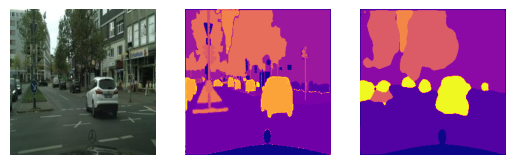

In [27]:
pic = plt.imread(trainpth + "/" + traindir[1])
img, mask = pic[:, :int(pic.shape[1]/2)], pic[:, int(pic.shape[1]/2):]
img, mask = np.array(img), np.array(mask, dtype=np.uint8)
mask = encode_segmap(mask)
label = predict(model, img)

plt.subplot(1, 3, 1)
plt.axis(False)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.axis(False)
plt.imshow(mask, cmap='plasma')
plt.subplot(1, 3, 3)
plt.axis(False)
plt.imshow(label, cmap='plasma')

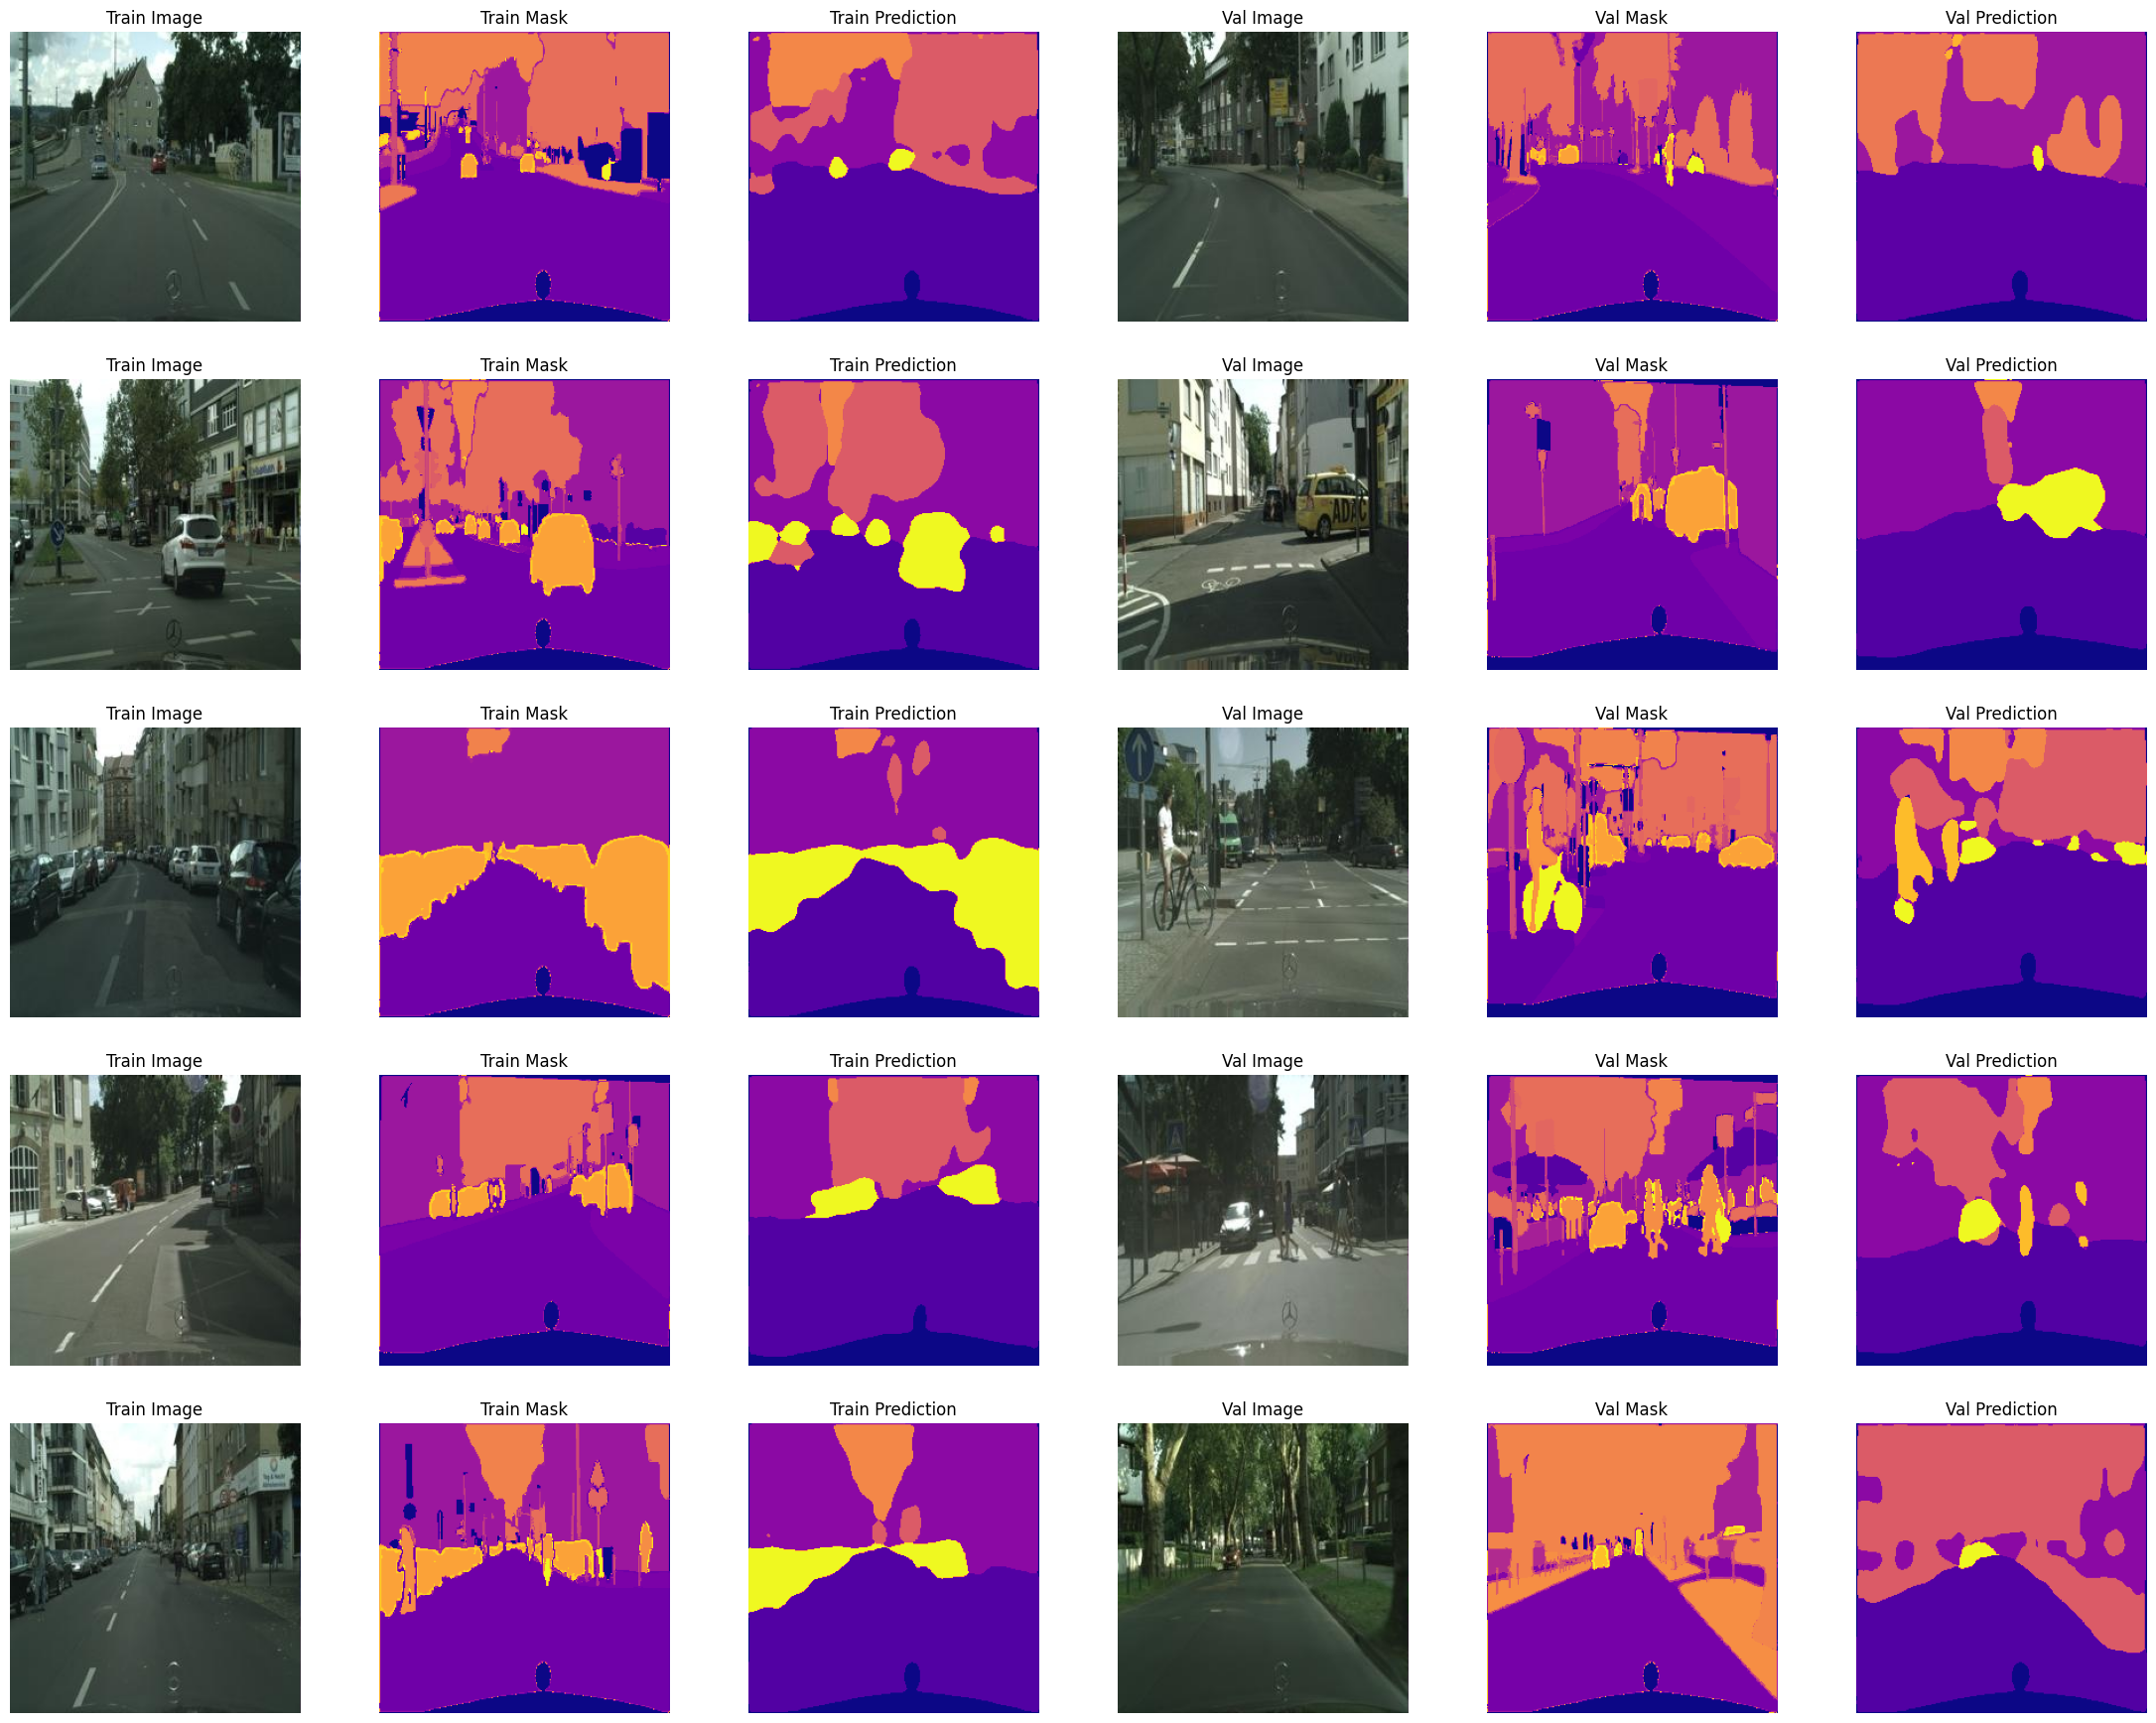

In [36]:
plt.figure(figsize=(28, 22))
for i in range(5):
  pic = plt.imread(trainpth + "/" + traindir[i])
  img, mask = pic[:, :int(pic.shape[1]/2)], pic[:, int(pic.shape[1]/2):]
  img, mask = np.array(img), np.array(mask, dtype=np.uint8)
  mask = encode_segmap(mask)
  label = predict(model, img)

  plt.subplot(5, 6, i*6+1)
  plt.axis(False)
  plt.title('Train Image')
  plt.imshow(img)
  plt.subplot(5, 6, i*6+2)
  plt.axis(False)
  plt.title('Train Mask')
  plt.imshow(mask, cmap='plasma')
  plt.subplot(5, 6, i*6+3)
  plt.axis(False)
  plt.title('Train Prediction')
  plt.imshow(label, cmap='plasma')

  pic = plt.imread(valpth + "/" + valdir[i])
  img, mask = pic[:, :int(pic.shape[1]/2)], pic[:, int(pic.shape[1]/2):]
  img, mask = np.array(img), np.array(mask, dtype=np.uint8)
  mask = encode_segmap(mask)
  label = predict(model, img)

  plt.subplot(5, 6, i*6+4)
  plt.axis(False)
  plt.title('Val Image')
  plt.imshow(img)
  plt.subplot(5, 6, i*6+5)
  plt.axis(False)
  plt.title('Val Mask')
  plt.imshow(mask, cmap='plasma')
  plt.subplot(5, 6, i*6+6)
  plt.axis(False)
  plt.title('Val Prediction')
  plt.imshow(label, cmap='plasma')

plt.show()